In [2]:
import sys
sys.path.insert(0, '../')
from lib import *

%matplotlib inline

DEBUG = False;


## Single Run

(-1000.0, 10000.0)

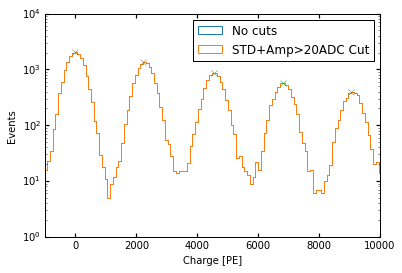

In [8]:
# WEEK="APSAIA_VUV_2";
WEEK="DAPHNE_VUV";

path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"
Runs=open_runs_table("../macros/"+WEEK+".xlsx")
Calib_run=Runs[(Runs["Type"]=="Calibration")].iloc[2] #2nd calib run, middle voltage 

Runs=Runs[Runs["Type"]=="Visible"]


for ch in [5]:
    r=0;

    for run in [Calib_run["Run"]]:
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)
    for run in [Runs.iloc[2]["Run"]]:
        run_path=path+"run"+str(run).zfill(2)+"/";
        Average_waveform  =open_ch_var(run_path ,"Avg_wvf"   ,ch,compressed=compress)

Ped_CUT=Pedestal_vars[ch]["STD"]<200
# Peak_CUT=Peak_vars[ch]["PeakTime"]<1100

plt.hist(Charge_vars[ch]["ChargeRangeAverageWvf"]                        ,500,np.array([-0.1,1.4])*3e4,histtype="step");
plt.hist(Charge_vars[ch]["ChargeRangeAverageWvf"][Ped_CUT]               ,500,np.array([-0.1,1.4])*3e4,histtype="step");
# plt.hist(Charge_vars[ch]["ChargeRangeAverageWvf"][Ped_CUT*Peak_CUT]               ,500,np.array([-0.1,1.4])*3e4,histtype="step");
counts,bins= np.histogram(Charge_vars[ch]["ChargeRangeAverageWvf"][Ped_CUT],500,np.array([-0.1,1.4])*3e4);

plt.legend(["No cuts","STD+Amp>20ADC Cut","STD+Amp>40ADC Cut","Best Fit"],loc="upper right")
plt.xlabel("Charge [PE]")
plt.ylabel("Events")
# plt.ylim([1,2e3])

peaks=find_peaks(counts,height=200,width=4)
plt.plot(bins[peaks[0]],peaks[1]["peak_heights"],"x")
plt.semilogy()
plt.xlim([-1e3,1e4])

## Deconvolution

In [9]:
for run in [3]:
    run_path=path+"run"+str(run).zfill(2)+"/";
    Pedestal_vars=open_ch_var(run_path,"Pedestal_vars",ch,compressed=compress)
    RawADC=open_ch_var(run_path,"RawADC",ch,compressed=True)
    ADC=substract_Pedestal((RawADC,Pedestal_vars,1))
    del RawADC


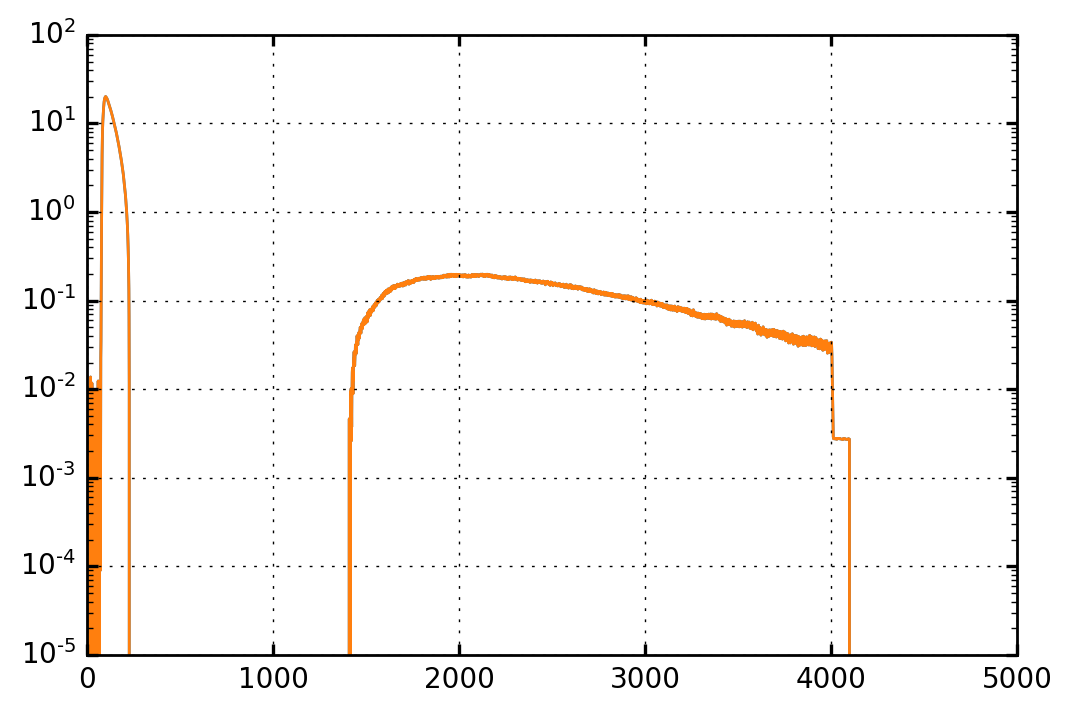

In [10]:
DEBUG=True
from lib.dec_functions import gauss

if WEEK=="DAPHNE_VUV"  : light2sPE_Factor=100/2.1;
if WEEK=="APSAIA_VUV_2": light2sPE_Factor=16*1.22;

XA_SER=Average_waveform["AvWvf_Center_Peak"]/light2sPE_Factor
presig=100

XA_SER=np.concatenate([XA_SER[np.argmax(XA_SER)-presig:],np.zeros(XA_SER[:np.argmax(XA_SER)-presig].shape[0])])

XA_SER_FFT  =np.fft.rfft(XA_SER) 



if DEBUG:
    plt.figure(dpi=200)
    plt.plot(XA_SER)
    plt.plot(XA_SER*(XA_SER>0))
    plt.grid()
    plt.semilogy()
    

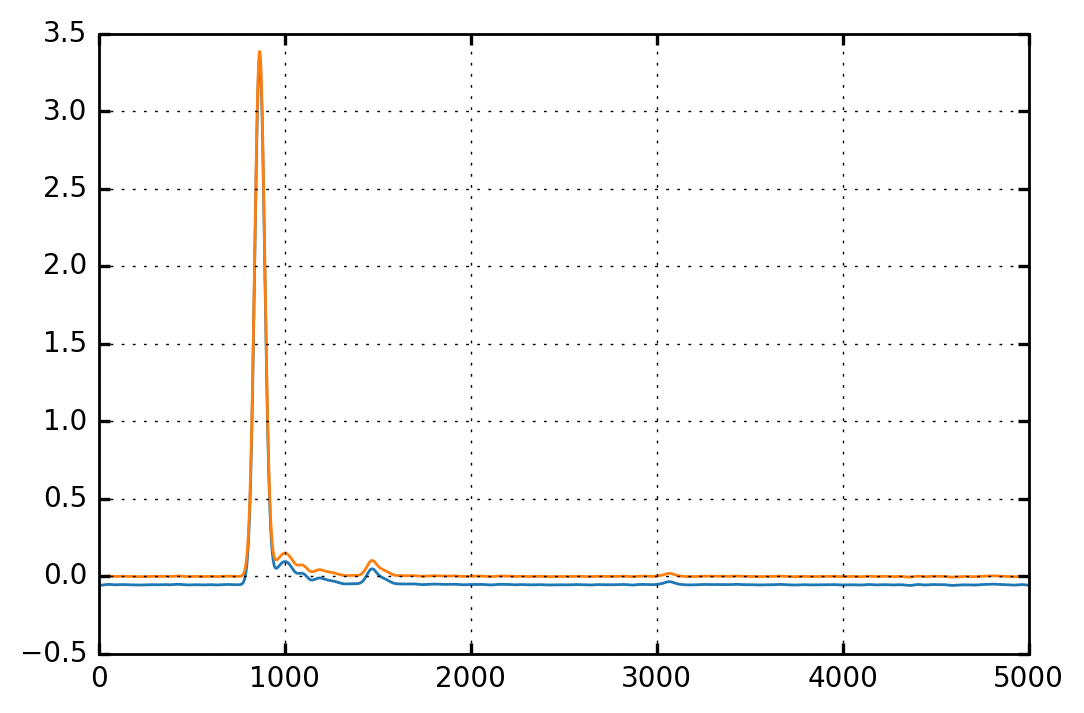

In [11]:

if WEEK=="DAPHNE_VUV"  : gauss_F=gauss(np.arange(len(XA_SER_FFT)),sigma=30,n=2);
if WEEK=="APSAIA_VUV_2": gauss_F=gauss(np.arange(len(XA_SER_FFT)),sigma=30,n=2);

# Deconvolve
# ADC_dec=deconvolve(ADC[:10],XA_SER,gauss_F)
ADC_dec=deconvolve(ADC,XA_SER,gauss_F)

plt.figure(dpi=200)
if DEBUG:
    plt.plot(ADC_dec[1])
#recalculate pedestal
Pedestal_vars_SW=compute_Pedestal_slidingWindows(ADC_dec)
ADC_dec=substract_Pedestal((ADC_dec,Pedestal_vars_SW,1))
if DEBUG:
    plt.plot(ADC_dec[1])

plt.grid()

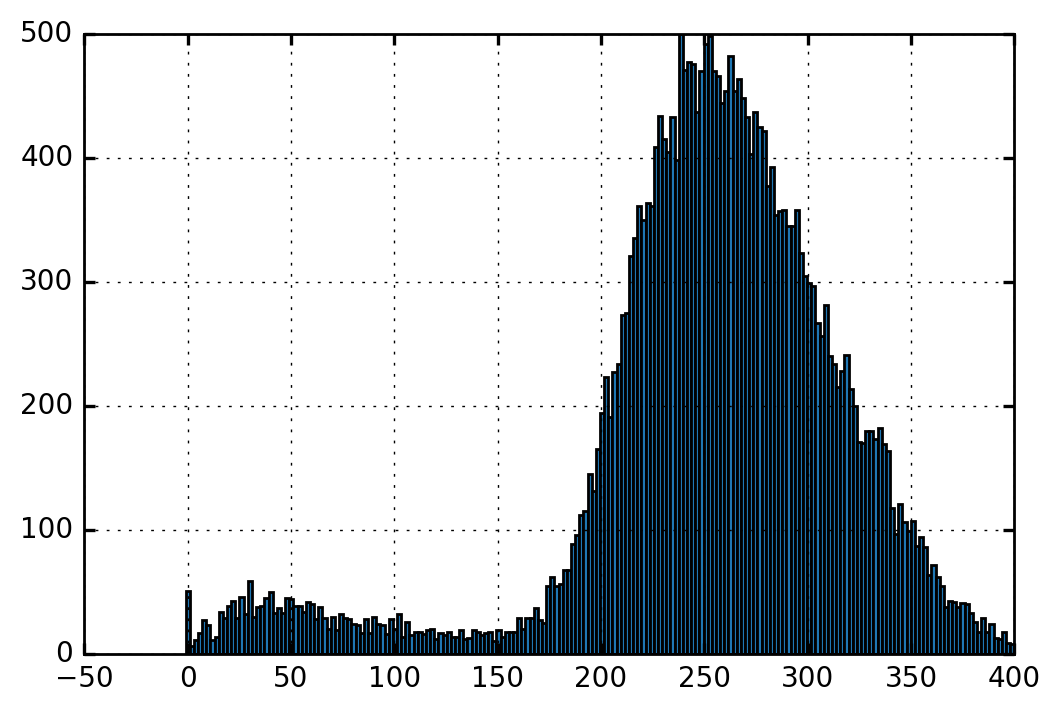

In [18]:


plt.figure(dpi=200)
fast =np.sum(ADC_dec[:,800:1200],axis=1)
fast*=(GetGains("DAPHNE_VUV",4,9))/(GetGains("DAPHNE_VUV",4,9))

# plt.hist(fast,200,[-1,20]);
# fast =np.sum(ADC_dec[:,800:1200],axis=1)
# fast*=(GetGains("DAPHNE_VUV",12)[-1])/(GetGains("DAPHNE_VUV",9)[-1])

plt.hist(fast,200,[-1,400]);
# plt.semilogy()
plt.grid()

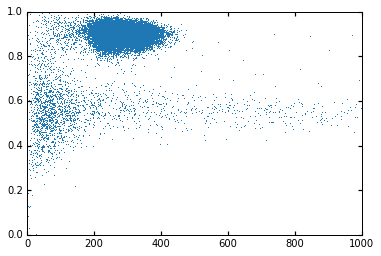

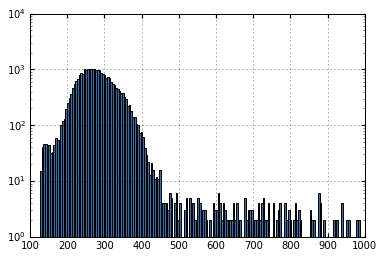

In [25]:

fast =np.sum(ADC_dec[:,500:1000],axis=1)
total=np.sum(ADC_dec[:,500:3000],axis=1)

plt.plot(total,fast/total,',')
plt.ylim([0,1])
plt.xlim([0,1000])
APSAIA_CUT=(fast>0.7)*(total>130)
plt.figure()
plt.hist(total[APSAIA_CUT],200,[100,1000]);
plt.semilogy()
plt.grid()

[]

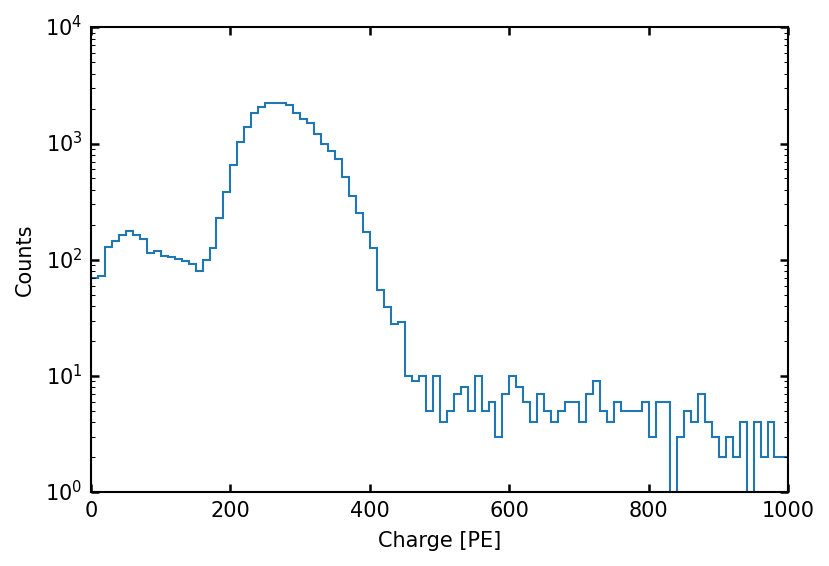

In [20]:
# plt.hist(np.argmax(ADC_dec,axis=1),200,[800,1e3]);
# plt.show().
plt.figure(dpi=150)
plt.hist(total,100,[0,1000],histtype="step");

plt.xlabel("Charge [PE]")
plt.ylabel("Counts")
plt.semilogy()


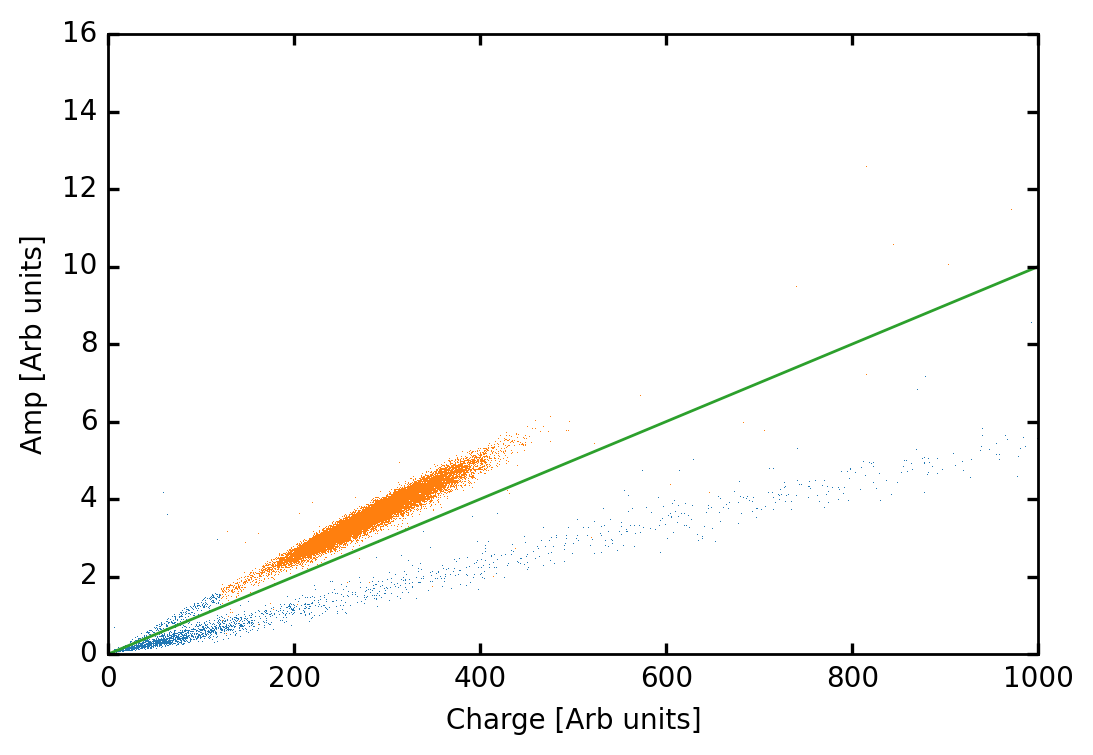

In [32]:
%matplotlib inline
#cuts
total
f90=fast/total
CUT_total=total>120
CUT_tf90=f90>0.7
CUT=CUT_tf90*CUT_total


plt.figure(dpi=200)
Amp=np.max(ADC_dec,axis=1)
plt.plot(total[~CUT],Amp[~CUT],",");
plt.plot(total[CUT] ,Amp[CUT] ,",");
# plt.ylim([0,1])
plt.xlim([0,1000])
plt.ylabel("Amp [Arb units]")
plt.xlabel("Charge [Arb units]")
x_ticks=np.arange(0,1000,1)
plt.plot(x_ticks,0.01*x_ticks)
plt.show()

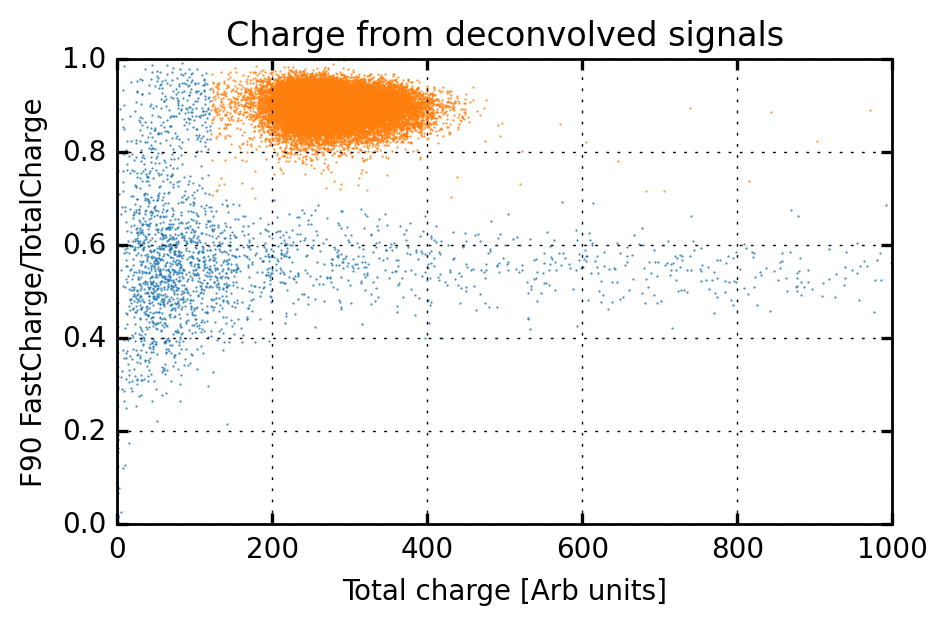

In [51]:
plt.figure(dpi=200,figsize=(5,3))
# plt.hist2d(total,fast/total,[100,100],[[0,1e4],[0,1]]);
# plt.hist2d(total,fast/total,[1000,1000],[[0,1e4],[0,1]]);
plt.plot(total[~CUT],f90[~CUT],".",markersize=0.5);
plt.plot(total[CUT],f90[CUT]  ,".",markersize=0.5);
plt.ylim([0,1])
plt.xlim([0,1000])

# plt.semilogy()
plt.xlabel("Total charge [Arb units]"             ,fontsize=10)
plt.ylabel("F90 FastCharge/TotalCharge"     ,fontsize=10)
plt.title("Charge from deconvolved signals" ,fontsize=12)
plt.grid()

Text(0.5, 0, 'Ticks [4ns each]')

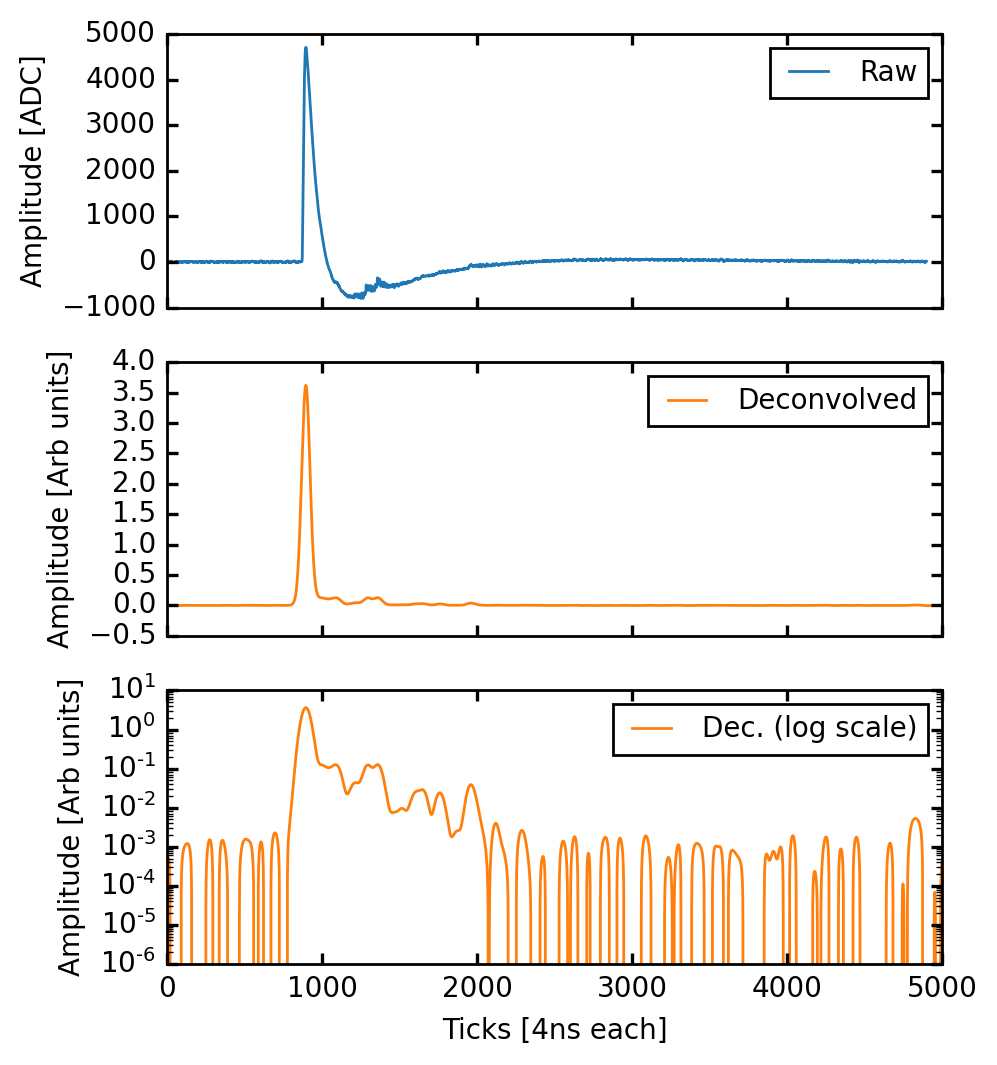

In [50]:
%matplotlib inline


fig,axs=plt.subplots(3,1,dpi=200,figsize=(5,6),sharex=True)

axs[0].plot(ADC[3][100:],label="Raw")
axs[0].set_ylabel("Amplitude [ADC]")
axs[0].legend(fontsize=10)
# plt.xlim([0,1000])
# plt.figure(dpi=100,figsize=(10,3))
axs[1].plot(ADC_dec[3],label="Deconvolved",color="tab:orange")
axs[1].set_ylabel("Amplitude [Arb units]")
# plt.figure(dpi=100,figsize=(10,3))
axs[1].legend(fontsize=10)

axs[2].plot(ADC_dec[3],color="tab:orange",label="Dec. (log scale)")
axs[2].set_ylabel("Amplitude [Arb units]")
axs[2].set_yscale("log")
axs[2].legend(fontsize=10)

plt.subplots_adjust(wspace=0, hspace=.2)
plt.xlabel("Ticks [4ns each]")


[]

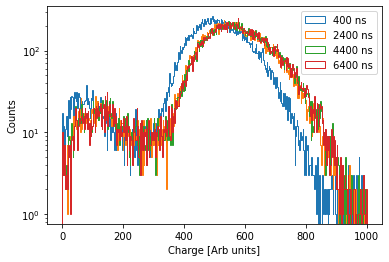

In [30]:
for i in range(1000,3000,500):
    charge=np.sum(ADC_dec[:,600:i],axis=1)
    plt.hist(charge,500,[0,1000],histtype="step",density=False,label=str((i-900)*4)+" ns");
plt.legend()

plt.xlabel("Charge [Arb units]")
plt.ylabel("Counts")
plt.semilogy()
# plt.xlim([300,800])

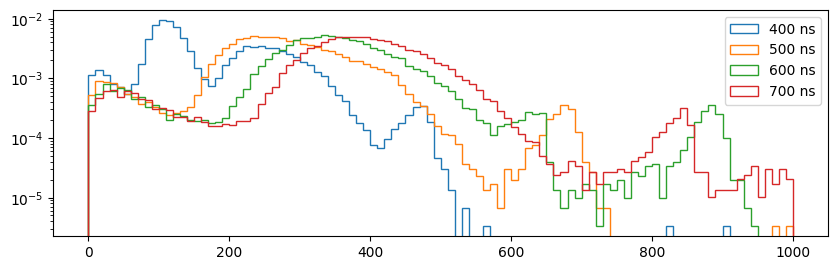

In [32]:
#not deconvolved charge
SPE_charge     =np.sum((XA_SER*(XA_SER>0))[0:1000])
SPE_charge_2   =np.sum(XA_SER*(XA_SER>0))          


plt.figure(dpi=100,figsize=(10,3))
for i in range(1000,1100,25):
    charge=np.sum(ADC[:,800:i],axis=1)/SPE_charge_2
    plt.hist(charge,100,[0,1000],histtype="step",density=True,label=str((i-900)*4)+" ns");
plt.semilogy()
plt.legend()




503.17507601874007
577.085402290948
0.871924803540699


(0.0, 1000.0)

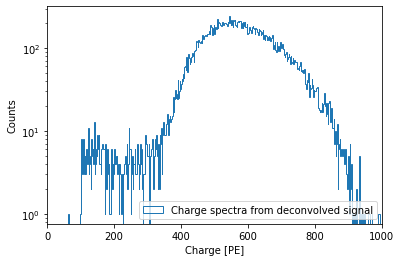

In [38]:
if WEEK=="DAPHNE_VUV"  : charge=np.sum(ADC[:,600:1150],axis=1);
if WEEK=="APSAIA_VUV_2": charge=np.sum(ADC[:,600:1050],axis=1);

charge_dec=np.sum(ADC_dec[:,600:3500],axis=1)

# plt.hist((charge/SPE_charge)[CUT],500,[0,1000],histtype="step",label="Raw");
plt.hist(charge_dec       [CUT],500,[0,1000],histtype="step"  ,label="Charge spectra from deconvolved signal");
plt.semilogy()
print(np.mean((charge/SPE_charge)[CUT]))
print(np.mean((charge_dec)[CUT]))
print(np.mean((charge/SPE_charge)[CUT])/np.mean((charge_dec)[CUT]))
ratio=np.mean((charge/SPE_charge)[CUT])/np.mean((charge_dec)[CUT])
# plt.hist((charge/SPE_charge/ratio)[CUT],500,[0,1000],histtype="step",label="Raw x Ratio (Deconvolved/Raw)");
plt.legend(loc="lower right")
plt.xlabel("Charge [PE]")
plt.ylabel("Counts")
plt.xlim([0,1000])

In [62]:
if WEEK=="DAPHNE_VUV": np.save("/afs/ciemat.es/user/r/rodrigoa/Daphne9OV_alpha_source_spectrum.npy",charge_dec[CUT])
if WEEK=="APSAIA_VUV_2": np.save("/afs/ciemat.es/user/r/rodrigoa/Apsaia2.5OV_alpha_source_spectrum.npy",charge_dec[CUT])

## SiPM

In [114]:
# WEEK="APSAIA_VUV_2";
WEEK="DAPHNE_VUV";

path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"

for run in [3]:
    run_path=path+"run"+str(run).zfill(2)+"/";
    compress=False
    Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[0,1],compressed=compress)



In [115]:

SAMPLING=4e-9
BITS= 16384
DYNAMIC_RANGE= 2
AMP= np.array([250,250,250,250,1030])
e_charge=1.60217663 * 1e-19

#                           ADCs to V     ticks to sec          C to e-      still need to correct by Gain of specific run
ADCxTicks2e=       DYNAMIC_RANGE/BITS     * SAMPLING  / AMP  /e_charge
if WEEK=="DAPHNE_VUV":   GAIN=np.array([6.83E+06,	7.18E+06	, 7.00E+06,	7.08E+06,	3.00E+06]) #from calibrations, AT 4/2.5v
if WEEK=="APSAIA_VUV_2": GAIN=np.array([6.75E+06,	6.98E+06	, 6.90E+06,	6.97E+06,	3.00E+06]) #from calibrations, AT 4/2.5v
ADCxTicks2PE=ADCxTicks2e/GAIN

# for ch in [0,1]:
#     for key in Charge_vars[ch]:
#         # plt.hist(Charge_vars[ch][key][CUT]*ADCxTicks2PE[ch],200,[0,40],label=key);
#         # print(np.mean( Charge_vars[ch][key][CUT][(Charge_vars[ch][key][CUT]*ADCxTicks2PE[ch]) <40]*ADCxTicks2PE[ch]))
# plt.xlim([0,5e4])
# plt.legend()
# plt.semilogy()
for key in Charge_vars[ch]:
    print(np.mean(
        Charge_vars[0][key][CUT][(Charge_vars[0][key][CUT]*ADCxTicks2PE[0]) <40]*ADCxTicks2PE[0]+
        Charge_vars[1][key][CUT][(Charge_vars[0][key][CUT]*ADCxTicks2PE[0]) <40]*ADCxTicks2PE[1]
                  
                  ))


33.76711785926348
34.109437971697275
32.85118350214153
28.856547718941368
29.262678026304382
27.748369094001703


## Calibration FIT

123.82790583038454


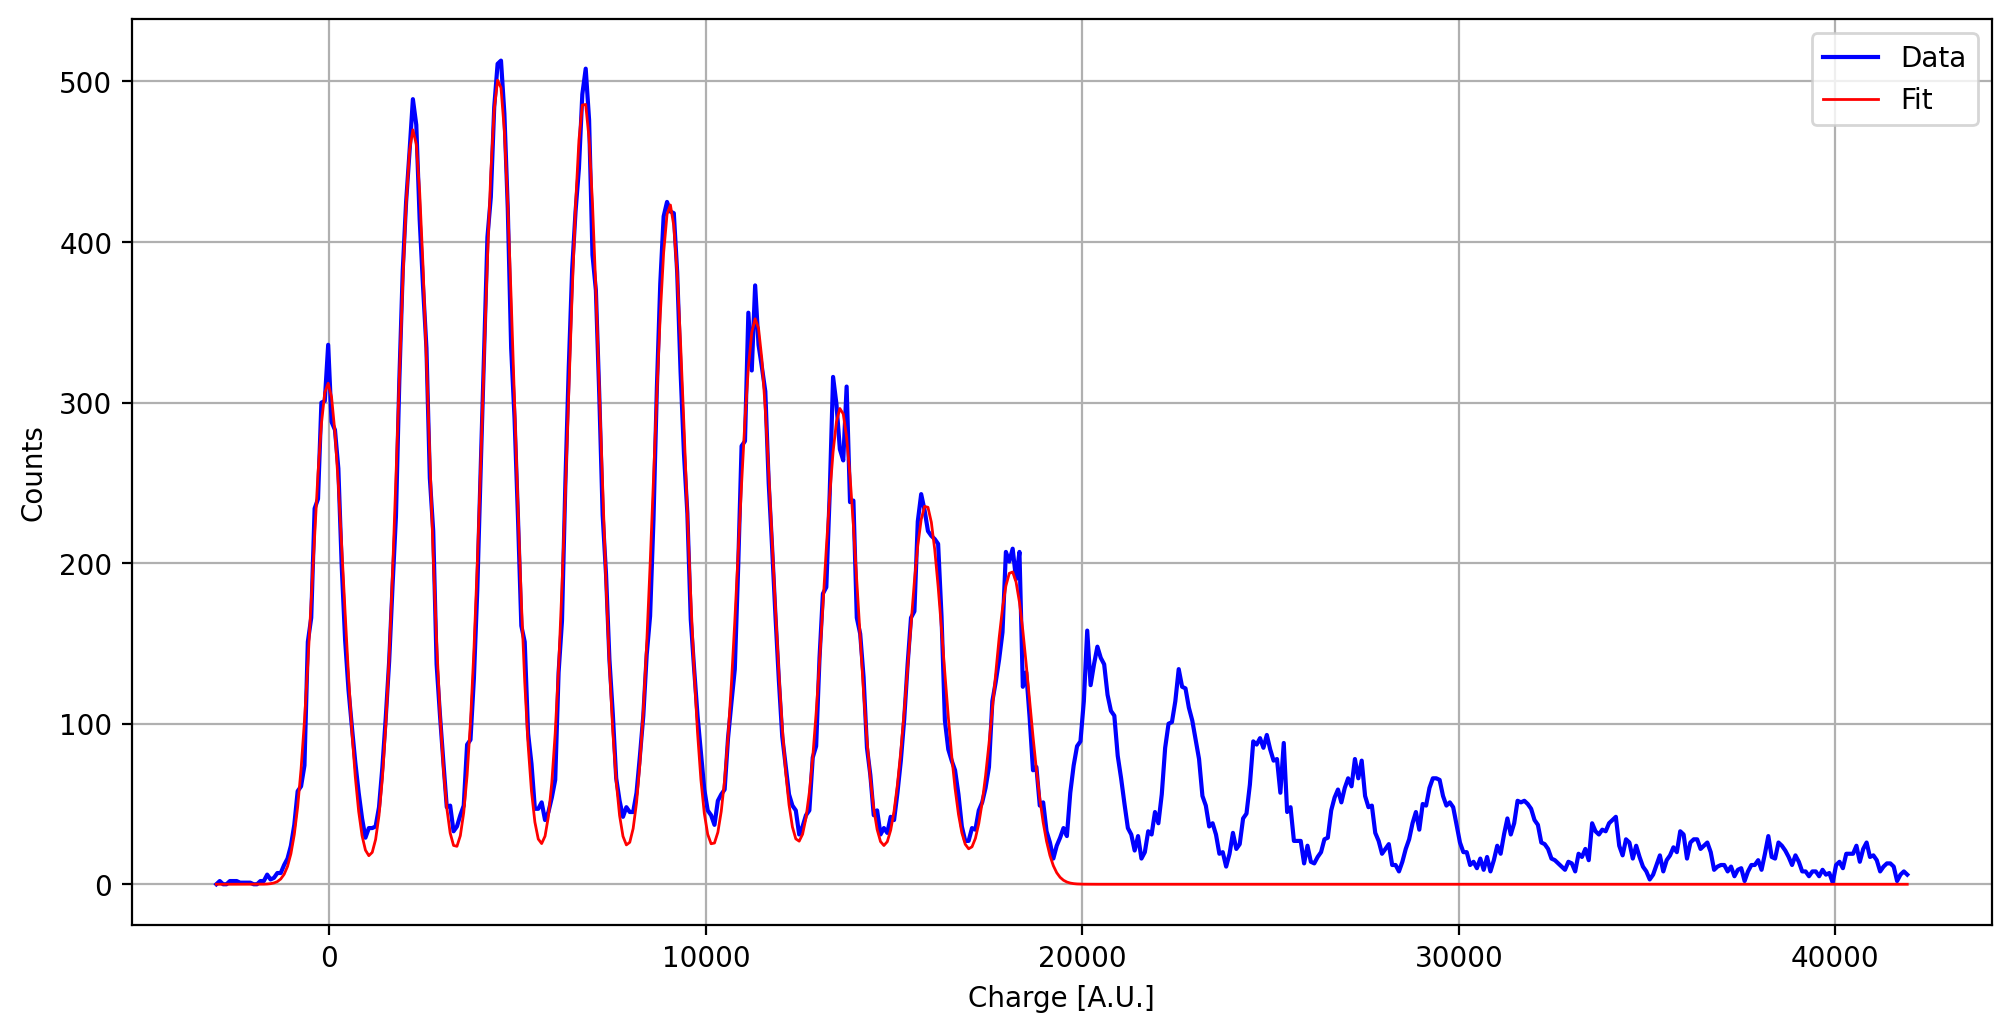

In [192]:
%matplotlib inline

def gauss(x,a,x0,sigma):
    return a*np.exp(-0.5*np.power((x-x0)/sigma,2))

def gaussian_train(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        height = params[i]
        center = params[i+1]
        width  = params[i+2]
        y      +=  gauss(x, height, center, width)
    return y

def fit_gaussians(x, y, *p0):
    assert x.shape == y.shape, "Input arrays must have the same shape."
    # try:
    popt, pcov = curve_fit(gaussian_train, x,y, p0=p0[0])
    fit_y=gaussian_train(x,*popt)
    chi_squared = np.sum((y[abs(fit_y)>0.1] - fit_y[abs(fit_y)>0.1]) ** 2 / fit_y[abs(fit_y)>0.1]) / (y.size - len(popt))
    plt.figure(dpi=200, figsize=(12, 6))
    fig = plt.axes()
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x, fit_y, 'r-', label='fit',linewidth=1)
    plt.grid()
    return popt,fig, chi_squared
    # except:
    #     print("Fit failed.")


params=np.zeros(len(peaks[0])*3)
params[0::3]=peaks[1]["peak_heights"]
params[1::3]=bins[peaks[0]]
params[2::3]=1e2
vars,fig,qs=fit_gaussians(bins[:-1],counts,params)
# print(vars*1e-6)
# fig.set_xlim([-1e4,0.98e4])
fig.set_xlabel("Charge [A.U.]")
fig.set_ylabel("Counts")
fig.legend(["Data","Fit"],loc="upper right")

gains=vars[1::3]-vars[1]
gains=gains[1:]-gains[0:-1]
# fig.text(0.4e8,430,"X-ARAPUCA Gain [1e6] \n =%0.2f" % (gains[0]*1e-6));
print(qs)


In [193]:
Amp=vars[0::3]
sigma=vars[2::3]
if DEBUG:
    print(Amp)
    print(sigma)

#prob is proportional to A*sigma (sqrt(2pi))
PNs=Amp*sigma/sum(Amp*sigma)
PNs_err=(Amp*sigma)**0.5/sum(Amp*sigma)

print(PNs)
print(PNs_err)




[0.09188188 0.13759971 0.14848721 0.1460418  0.12760674 0.11080109
 0.09528269 0.07738538 0.06491349]
[0.00025542 0.00031257 0.0003247  0.00032201 0.000301   0.00028048
 0.0002601  0.0002344  0.00021469]


In [194]:
from math import factorial as fact
import numpy as np
from scipy.stats import poisson
def B(i,k):
    #factorial factor of F
    if (i==0) & (k==0):return 1;
    if (i==0) & (k>0): return 0;
    else:
        return (fact(k-1) * fact(k)
                /(fact(i-1)*fact(i)*fact(k-i) )
               )

def F(K,p,L):
    ## computes prob of the kth point in a convoluted poisson+binomial distribution, 
    # L is the mean value of the poisson, p is the binomial coef, i.e. the crosstalk we want to compute
    

    aux_sum=0
    for i in range(K+1):
        aux_sum+=B(i,K)*((L *(1 - p))**i)  *  (p**(K - i)) 

    return np.exp(-L)*aux_sum/fact(K);

def PoissonPlusBinomial(x,p,L):
    N=len(x)
    aux=np.zeros(shape=N)
    for i in range(N):aux[i]= F(x[i],p,L);
    
    return aux/sum(aux);


Initial: 5 0.3726795106447037 	 2.3872514001729463
Fitted:  [0.46161338 2.48668347]
Rel Error:  [3.4405516 1.706023 ]
chi-square
12.867250864725671


Text(0.5, 0, 'Calibration Peak')

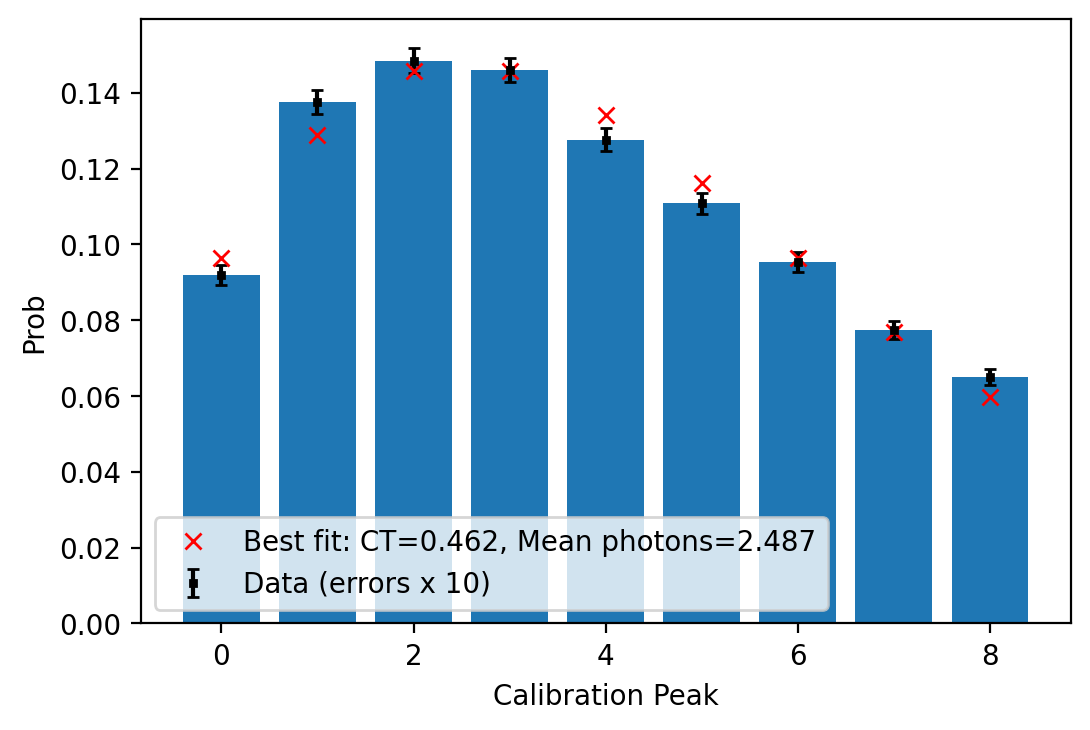

In [223]:
P0=PNs[0]
P1=PNs[1]
l=-np.log(P0)
p=1-P1/(l*P0)
print("Initial:",ch,p,"\t",l)

fig, ax = plt.subplots(1,dpi=200)

xdata=range(len(PNs))


plt.errorbar(x=xdata,y=PNs,yerr=PNs_err*10, color="k",label=("Data (errors x 10)"),linestyle="none",marker="s",markersize=2,capsize=2,)
plt.bar(xdata,PNs)

p0=[p,l]
popt, pcov = curve_fit(PoissonPlusBinomial, xdata,PNs,sigma=PNs_err*10, p0=p0)

plt.plot(xdata, PoissonPlusBinomial(xdata, *popt), 'x',label='Best fit: CT=%5.3f, Mean photons=%5.3f' % tuple(popt),color="red")



print("Fitted: ",popt)
perr = np.sqrt(np.diag(pcov))
print("Rel Error: ", perr/popt*100)


residuals = PNs - PoissonPlusBinomial(xdata, *popt)
fres = sum((residuals**2)/PNs)/(residuals.size - len(popt))*np.sum(counts)
print ('chi-square')
print(fres) #THIS IS YOUR CHI-SQUARE VALUE!print(chi)
#Chisq: 

# prepare confidence level curves
nstd = 2. # to draw 5-sigma intervals
popt_up = popt + nstd * perr
popt_dw = popt - nstd * perr

fit    = PoissonPlusBinomial(xdata, *popt)
fit_up = PoissonPlusBinomial(xdata, *popt_up)
fit_dw = PoissonPlusBinomial(xdata, *popt_dw)
# ax.fill_between             (xdata, fit_up, fit_dw, alpha=.25, label=str(int(nstd))+"-sigma interval")

 
plt.legend()
# plt.plot(x,'o-',label="Poisson +  Binomial p*100="+str(int(ct*100)) )
plt.ylabel("Prob")
plt.xlabel("Calibration Peak")
